In [1]:
import torch

In [2]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForQuestionAnswering
import time

In [3]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [4]:
%%capture
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

In [5]:
# Define the path to the SQuAD 2.0 training data
path = "squad/train-v2.0.json"

# Load and preprocess the SQuAD 2.0 data
def load_squad_data(path):
    with open(path, 'rb') as f:
        squad_dict = json.load(f)
        
    texts = []
    questions = []
    answers = []

    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    texts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return texts, questions, answers

# Preprocess the data to find answer start and end positions
train_texts, train_queries, train_answers = load_squad_data(path)

In [6]:
# Give the path for SQuAD 2.0 validation data
path = Path('squad/dev-v2.0.json')

# Load and preprocess the SQuAD 2.0 data
def load_squad_data(path):
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    texts = []
    questions = []
    answers = []

    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    texts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return texts, questions, answers

# Preprocess the data to find answer start and end positions
val_texts, val_queries, val_answers = load_squad_data(path)

In [7]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

86821
86821
86821


In [8]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

20302
20302
20302


In [9]:
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

In [10]:
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2


In [11]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [12]:
train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

In [13]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    
    count = 0
    
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))
        
        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
            
        # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
        if end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
            
            # if end position is still None the answer passage has been truncated
            if end_positions[-1] is None:
                count += 1
                end_positions[-1] = tokenizer.model_max_length
    print(count)
    
    # Update the data in dictionary
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

In [14]:
add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

13
17


In [15]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [16]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

In [19]:
model = BertForQuestionAnswering.from_pretrained('bert-base-cased').to(device)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from transformers import AdamW
optim = AdamW(model.parameters(), lr=5e-5)

epochs = 3

/home/sa.ekbote/.local/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
from collections import Counter
import string
import re

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    
    def white_space_fix(text):
        return ' '.join(text.split())
    
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    
    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def exact_match_score(prediction, ground_truth):
    return normalize_answer(prediction) == normalize_answer(ground_truth)

In [22]:
from torch.cuda.amp import GradScaler, autocast

def train_and_evaluate(model, train_loader, val_loader, optimizer, epochs, model_save_path):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    print_every = 1000  # Print every 500 steps
    scaler = GradScaler()  # Initialize the gradient scaler for mixed precision training

    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0
        total_train_exact_match = 0
        total_train_f1 = 0
        total_train_examples = 0

        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            with autocast():  # Enable automatic mixed precision
                outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
                loss = outputs.loss

            # Backward pass with mixed precision
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += loss.item()

            # Convert logits to answer spans (this part is not affected by mixed precision)
            start_logits, end_logits = outputs.start_logits, outputs.end_logits
            start_predictions = torch.argmax(start_logits, dim=-1)
            end_predictions = torch.argmax(end_logits, dim=-1)

            for i in range(input_ids.size(0)):
                start_pred = start_predictions[i].item()
                end_pred = end_predictions[i].item()
                predicted_answer = tokenizer.decode(input_ids[i, start_pred:end_pred + 1])

                ground_truth_answer = tokenizer.decode(input_ids[i, start_positions[i]:end_positions[i] + 1])

                total_train_exact_match += exact_match_score(predicted_answer, ground_truth_answer)
                total_train_f1 += f1_score(predicted_answer, ground_truth_answer)
                total_train_examples += 1

            if (batch_idx + 1) % print_every == 0:
                print(f"Train Epoch: {epoch + 1} [{batch_idx + 1}/{len(train_loader)}]\tLoss: {loss.item():.6f}\tExact Match: {total_train_exact_match / total_train_examples:.4f}\tF1: {total_train_f1 / total_train_examples:.4f}")

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_exact_match = total_train_exact_match / total_train_examples
        avg_train_f1 = total_train_f1 / total_train_examples

        train_losses.append(avg_train_loss)
        train_accuracies.append((avg_train_exact_match, avg_train_f1))

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_exact_match = 0
        total_val_f1 = 0
        total_val_examples = 0

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                start_positions = batch['start_positions'].to(device)
                end_positions = batch['end_positions'].to(device)

                with autocast():  # Enable automatic mixed precision for evaluation
                    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
                    loss = outputs.loss

                total_val_loss += loss.item()

                # Convert logits to answer spans (this part is not affected by mixed precision)
                start_logits, end_logits = outputs.start_logits, outputs.end_logits
                start_predictions = torch.argmax(start_logits, dim=-1)
                end_predictions = torch.argmax(end_logits, dim=-1)

                for i in range(input_ids.size(0)):
                    start_pred = start_predictions[i].item()
                    end_pred = end_predictions[i].item()
                    predicted_answer = tokenizer.decode(input_ids[i, start_pred:end_pred + 1])

                    ground_truth_answer = tokenizer.decode(input_ids[i, start_positions[i]:end_positions[i] + 1])

                    total_val_exact_match += exact_match_score(predicted_answer, ground_truth_answer)
                    total_val_f1 += f1_score(predicted_answer, ground_truth_answer)
                    total_val_examples += 1

                if (batch_idx + 1) % print_every == 0:
                    print(f"Val Epoch: {epoch + 1} [{batch_idx + 1}/{len(val_loader)}]\tLoss: {loss.item():.6f}\tExact Match: {total_val_exact_match / total_val_examples:.4f}\tF1: {total_val_f1 / total_val_examples:.4f}")

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_exact_match = total_val_exact_match / total_val_examples
        avg_val_f1 = total_val_f1 / total_val_examples

        val_losses.append(avg_val_loss)
        val_accuracies.append((avg_val_exact_match, avg_val_f1))

        print(f'Epoch {epoch + 1}/{epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Exact Match: {avg_train_exact_match:.4f}, Train F1: {avg_train_f1:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Exact Match: {avg_val_exact_match:.4f}, Val F1: {avg_val_f1:.4f}')

        # Save the model after each epoch
        torch.save(model.state_dict(), f"{model_save_path}/model_epoch_{epoch + 1}.pth")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [23]:

# Example usage
model_save_path = "/home/sa.ekbote/cai6307-parsingpandas/bert_squad_v2/"
train_losses, train_accuracies, val_losses, val_accuracies = train_and_evaluate(model, train_loader, val_loader, optim, epochs, model_save_path)


Train Epoch: 1 [1000/10853]	Loss: 2.505325	Exact Match: 0.3407	F1: 0.4618
Train Epoch: 1 [2000/10853]	Loss: 1.322605	Exact Match: 0.4218	F1: 0.5527
Train Epoch: 1 [3000/10853]	Loss: 0.945814	Exact Match: 0.4588	F1: 0.5938
Train Epoch: 1 [4000/10853]	Loss: 0.816831	Exact Match: 0.4818	F1: 0.6186
Train Epoch: 1 [5000/10853]	Loss: 1.080849	Exact Match: 0.4969	F1: 0.6351
Train Epoch: 1 [6000/10853]	Loss: 1.007084	Exact Match: 0.5059	F1: 0.6451
Train Epoch: 1 [7000/10853]	Loss: 0.526085	Exact Match: 0.5144	F1: 0.6536
Train Epoch: 1 [8000/10853]	Loss: 0.571599	Exact Match: 0.5215	F1: 0.6606
Train Epoch: 1 [9000/10853]	Loss: 1.702614	Exact Match: 0.5271	F1: 0.6665
Train Epoch: 1 [10000/10853]	Loss: 0.677151	Exact Match: 0.5326	F1: 0.6724
Val Epoch: 1 [1000/2538]	Loss: 1.196064	Exact Match: 0.5795	F1: 0.7306
Val Epoch: 1 [2000/2538]	Loss: 0.826177	Exact Match: 0.5787	F1: 0.7300
Epoch 1/3:
Train Loss: 1.3712, Train Exact Match: 0.5365, Train F1: 0.6764
Val Loss: 1.2536, Val Exact Match: 0.5795,

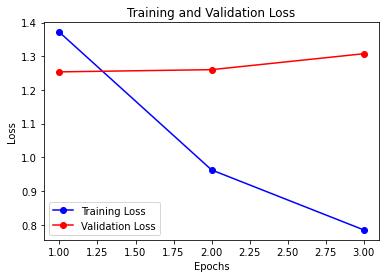

In [24]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming train_losses and val_losses are populated from the train_and_evaluate function
plot_losses(train_losses, val_losses)


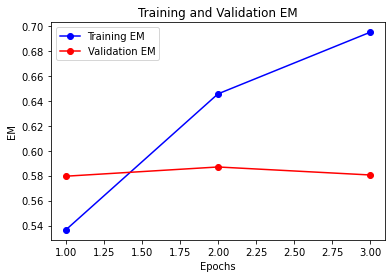

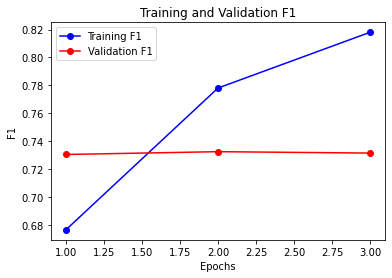

In [25]:
def plot_accuracies(train_accuracies, val_accuracies, metric_name):
    epochs = range(1, len(train_accuracies) + 1)
    train_scores = [score[0] if metric_name == 'EM' else score[1] for score in train_accuracies]
    val_scores = [score[0] if metric_name == 'EM' else score[1] for score in val_accuracies]

    plt.plot(epochs, train_scores, 'bo-', label=f'Training {metric_name}')
    plt.plot(epochs, val_scores, 'ro-', label=f'Validation {metric_name}')
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# Assuming train_accuracies and val_accuracies are populated from the train_and_evaluate function
plot_accuracies(train_accuracies, val_accuracies, 'EM')  # Plot for Exact Match
plot_accuracies(train_accuracies, val_accuracies, 'F1')  # Plot for F1 Score


In [26]:
# Save model to Google Drive
torch.save(model, '/home/sa.ekbote/cai6307-parsingpandas/models/bert-base-cased')

In [27]:
bert_model2 = torch.load('/home/sa.ekbote/cai6307-parsingpandas/models/bert-base-cased',map_location=torch.device('cpu'))
bert_model2.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [28]:
def predict(context,query):
    
    inputs = tokenizer.encode_plus(query, context, return_tensors='pt')
    outputs = bert_model2(**inputs)
    answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(outputs[1]) + 1 
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    return answer

def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
    
    def white_space_fix(text):
        return " ".join(text.split())
    
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    
    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    return 2 * (prec * rec) / (prec + rec)

In [29]:
def give_an_answer(context,query,answer):
    prediction = predict(context,query)
    em_score = compute_exact_match(prediction, answer)
    f1_score = compute_f1(prediction, answer)
    print(f"Question: {query}")
    print(f"Prediction: {prediction}")
    print(f"True Answer: {answer}")
    print(f"EM: {em_score}")
    print(f"F1: {f1_score}")
    print("\n")

In [32]:
def is_answerable(context, answer):
    # Normalize both the context and the answer
    normalized_context = normalize_text(context)
    normalized_answer = normalize_text(answer)
    
    # Check if the normalized answer is in the normalized context
    return normalized_answer in normalized_context

# Now let's filter out the unanswerable questions
context = "Hi! My name is Alexa and I am 21 years old. I used to live in Peristeri of Athens, but now I moved on in Kaisariani of Athens."

queries = [
    "How old is Alexa?",
    "Where does Alexa live now?",
    "Where Alexa used to live?",
    "What is the capital of France?"  # This question is unanswerable based on the context provided
]

answers = [
    "21",
    "Kaisariani of Athens",
    "Peristeri of Athens",
    "Paris"  # This answer is not present in the context, so the question is unanswerable
]

# Using a list comprehension to filter only answerable questions based on the context
answerable_pairs = [(q, a) for q, a in zip(queries, answers) if is_answerable(context, a)]

# Process only answerable questions
for q, a in answerable_pairs:
    give_an_answer(context, q, a)


Question: How old is Alexa?
Prediction: 21 years old.
True Answer: 21
EM: 0
F1: 0.5


Question: Where does Alexa live now?
Prediction: Peristeri of Athens,
True Answer: Kaisariani of Athens
EM: 0
F1: 0.6666666666666666


Question: Where Alexa used to live?
Prediction: Peristeri of Athens,
True Answer: Peristeri of Athens
EM: 1
F1: 1.0




In [31]:
context = """ Queen are a British rock band formed in London in 1970. Their classic line-up was Freddie Mercury (lead vocals, piano), 
            Brian May (guitar, vocals), Roger Taylor (drums, vocals) and John Deacon (bass). Their earliest works were influenced 
            by progressive rock, hard rock and heavy metal, but the band gradually ventured into more conventional and radio-friendly 
            works by incorporating further styles, such as arena rock and pop rock. """

queries = ["When did Queen found?",
           "Who were the basic members of Queen band?",
           "What kind of band they are?"
          ]
answers = ["1970",
           "Freddie Mercury, Brian May, Roger Taylor and John Deacon",
           "rock"
          ]

for q,a in zip(queries,answers):
    give_an_answer(context,q,a)

Question: When did Queen found?
Prediction: 1970.
True Answer: 1970
EM: 1
F1: 1.0


Question: Who were the basic members of Queen band?
Prediction: Freddie Mercury ( lead vocals, piano ), Brian May ( guitar, vocals ), Roger Taylor ( drums, vocals ) and John Deacon ( bass ).
True Answer: Freddie Mercury, Brian May, Roger Taylor and John Deacon
EM: 0
F1: 0.6923076923076924


Question: What kind of band they are?
Prediction: British rock
True Answer: rock
EM: 0
F1: 0.6666666666666666




In [33]:
context = """ Mount Olympus is the highest mountain in Greece. It is part of the Olympus massif near 
              the Gulf of Thérmai of the Aegean Sea, located in the Olympus Range on the border between 
              Thessaly and Macedonia, between the regional units of Pieria and Larissa, about 80 km (50 mi) 
              southwest from Thessaloniki. Mount Olympus has 52 peaks and deep gorges. The highest peak, 
              Mytikas, meaning "nose", rises to 2917 metres (9,570 ft). """

queries = [
           "How many metres is Olympus?",
           "Where Olympus is near?",
           "How far away is Olympus from Thessaloniki?"
          ]
answers = [
           "2917",
           "Gulf of Thérmai of the Aegean Sea",
           "80 km (50 mi)"
          ]

for q,a in zip(queries,answers):
    give_an_answer(context,q,a)

Question: How many metres is Olympus?
Prediction: 2917
True Answer: 2917
EM: 1
F1: 1.0


Question: Where Olympus is near?
Prediction: the Gulf of Thérmai of the Aegean Sea,
True Answer: Gulf of Thérmai of the Aegean Sea
EM: 1
F1: 0.8333333333333334


Question: How far away is Olympus from Thessaloniki?
Prediction: 80 km ( 50 mi )
True Answer: 80 km (50 mi)
EM: 1
F1: 1.0




In [34]:
context = """ The COVID-19 pandemic, also known as the coronavirus pandemic, is an ongoing pandemic of coronavirus disease 2019 (COVID-19) 
              caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). It was first identified in December 2019 in Wuhan, China. 
              The World Health Organization declared the outbreak a Public Health Emergency of International Concern in January 2020 and a pandemic 
              in March 2020. As of 6 February 2021, more than 105 million cases have been confirmed, with more than 2.3 million deaths attributed to COVID-19.
              Symptoms of COVID-19 are highly variable, ranging from none to severe illness. The virus spreads mainly through the air when people are 
              near each other.[b] It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. 
              It may also spread via contaminated surfaces. People remain infectious for up to two weeks, and can spread the virus even if they do not show symptoms.[9]"""

queries = [
           "What is COVID-19?",
           "What is caused by COVID-19?",
           "How many cases have been confirmed from COVID-19?",
           "How many deaths have been confirmed from COVID-19?",
           "How is COVID-19 spread?",
           "How long can an infected person remain infected?",
           "Can a infected person spread the virus even if they don't have symptoms?",
           "What do elephants eat?"
          ]
answers = [
           "an ongoing pandemic of coronavirus disease 2019",
           "severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)",
           "more than 105 million cases",
           "more than 2.3 million deaths",
           "mainly through the air when people are near each other. It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. It may also spread via contaminated surfaces.",
           "up to two weeks",
           "yes",
           " "
          ]

for q,a in zip(queries,answers):
      give_an_answer(context,q,a)

Question: What is COVID-19?
Prediction: 
True Answer: an ongoing pandemic of coronavirus disease 2019
EM: 0
F1: 0


Question: What is caused by COVID-19?
Prediction: 
True Answer: severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)
EM: 0
F1: 0


Question: How many cases have been confirmed from COVID-19?
Prediction: 2. 3 million
True Answer: more than 105 million cases
EM: 0
F1: 0.25


Question: How many deaths have been confirmed from COVID-19?
Prediction: 2. 3 million
True Answer: more than 2.3 million deaths
EM: 0
F1: 0.25


Question: How is COVID-19 spread?
Prediction: through the air when people are near each other.
True Answer: mainly through the air when people are near each other. It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. It may also spread via contaminated surfaces.
EM: 0
F1: 0.35555555555555557


Question: How long can an infected person remain infected?
Prediction: up to two weeks,

In [35]:
context = """ Harry Potter is a series of seven fantasy novels written by British author, J. K. Rowling. The novels chronicle the lives of a young wizard, 
              Harry Potter, and his friends Hermione Granger and Ron Weasley, all of whom are students at Hogwarts School of Witchcraft and Wizardry. 
              The main story arc concerns Harry's struggle against Lord Voldemort, a dark wizard who intends to become immortal, overthrow the wizard 
              governing body known as the Ministry of Magic and subjugate all wizards and Muggles (non-magical people). Since the release of the first novel, 
              Harry Potter and the Philosopher's Stone, on 26 June 1997, the books have found immense popularity, positive reviews, and commercial success worldwide. 
              They have attracted a wide adult audience as well as younger readers and are often considered cornerstones of modern young adult literature.[2] 
              As of February 2018, the books have sold more than 500 million copies worldwide, making them the best-selling book series in history, and have been translated 
              into eighty languages.[3] The last four books consecutively set records as the fastest-selling books in history, with the final installment selling roughly 
              eleven million copies in the United States within twenty-four hours of its release.  """

queries = [
           "Who wrote Harry Potter's novels?",
           "Who are Harry Potter's friends?",
           "Who is the enemy of Harry Potter?",
           "What are Muggles?",
           "Which is the name of Harry Poter's first novel?",
           "When did the first novel release?",
           "Who was attracted by Harry Potter novels?",
           "How many languages Harry Potter has been translated into? "
          ]
answers = [
           "J. K. Rowling",
           "Hermione Granger and Ron Weasley",
           "Lord Voldemort",
           "non-magical people",
           "Harry Potter and the Philosopher's Stone",
           "26 June 1997",
           "a wide adult audience as well as younger readers",
           "eighty"
          ]

for q,a in zip(queries,answers):
      give_an_answer(context,q,a)

Question: Who wrote Harry Potter's novels?
Prediction: J. K. Rowling.
True Answer: J. K. Rowling
EM: 1
F1: 1.0


Question: Who are Harry Potter's friends?
Prediction: Hermione Granger and Ron Weasley,
True Answer: Hermione Granger and Ron Weasley
EM: 1
F1: 1.0


Question: Who is the enemy of Harry Potter?
Prediction: Harry Potter? [SEP] Harry Potter is a series of seven fantasy novels written by British author, J. K. Rowling. The novels chronicle the lives of a young wizard,
True Answer: Lord Voldemort
EM: 0
F1: 0


Question: What are Muggles?
Prediction: non - magical people )
True Answer: non-magical people
EM: 0
F1: 0.4


Question: Which is the name of Harry Poter's first novel?
Prediction: Harry Potter and the Philosopher ' s Stone,
True Answer: Harry Potter and the Philosopher's Stone
EM: 0
F1: 0.7272727272727272


Question: When did the first novel release?
Prediction: 26 June 1997,
True Answer: 26 June 1997
EM: 1
F1: 1.0


Question: Who was attracted by Harry Potter novels?
Pred

In [50]:
!pip install optuna

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.1 MB/s eta 0:00:00
DEPRECATION: autogenes 1.0.4 has a non-standard dependency specifier matplotlib>=3.0.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of autogenes or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [46]:
import optuna
from transformers import BertConfig, BertForQuestionAnswering

def objective(trial):
    # Define the search space for the number of attention heads
    num_attention_heads = trial.suggest_categorical('num_attention_heads', [4, 8, 12, 16])

    # Load the pre-trained BERT model with the specified number of attention heads
    config = BertConfig.from_pretrained('bert-base-cased', num_attention_heads=num_attention_heads,  hidden_size=768)
    model = BertForQuestionAnswering.from_pretrained('bert-base-cased', config=config).to(device)
    
    from transformers import AdamW
    optim = AdamW(model.parameters(), lr=5e-5)
    model_save_path= '/home/sa.ekbote/cai6307-parsingpandas/num-heads/'

    epochs = 3
    # Train and evaluate the model (you can use your existing train_and_evaluate function)
    train_losses, train_accuracies, val_losses, val_accuracies =  train_and_evaluate(model, train_loader, val_loader, optim, epochs, model_save_path)


    # Return the objective value (e.g., the average of the last few validation F1 scores)
    return sum([f1 for _, f1 in val_accuracies[-3:]]) / 3 # Average of the last 3 epochs' F1 scores

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)  # Adjust the number of trials as needed

print(f"Best number of attention heads: {study.best_params['num_attention_heads']}")
print(f"Best F1 score: {study.best_value}")


[I 2024-04-05 16:45:24,268] A new study created in memory with name: no-name-64470793-1358-46de-b310-d6e14beabd15
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Epoch: 1 [1000/10853]	Loss: 1.246460	Exact Match: 0.3430	F1: 0.4652
Train Epoch: 1 [2000/10853]	Loss: 1.476093	Exact Match: 0.4181	F1: 0.5513
Train Epoch: 1 [3000/10853]	Loss: 1.423202	Exact Match: 0.4567	F1: 0.5917
Train Epoch: 1 [4000/10853]	Loss: 1.414765	Exact Match: 0.4769	F1: 0.6139
Train Epoch: 1 [5000/10853]	Loss: 1.793976	Exact Match: 0.4904	F1: 0.6285
Train Epoch: 1 [6000/10853]	Loss: 0.584310	Exact Match: 0.5029	F1: 0.6412
Train Epoch: 1 [7000/10853]	Loss: 1.085196	Exact Match: 0.5120	F1: 0.6505
Train Epoch: 1 [8000/10853]	Loss: 1.141405	Exact Match: 0.5197	F1: 0.6579
Train Epoch: 1 [9000/10853]	Loss: 1.347730	Exact Match: 0.5260	F1: 0.6645
Train Epoch: 1 [10000/10853]	Loss: 2.219108	Exact Match: 0.5319	F1: 0.6703
Val Epoch: 1 [1000/2538]	Loss: 0.942244	Exact Match: 0.5823	F1: 0.7244
Val Epoch: 1 [2000/2538]	Loss: 1.180310	Exact Match: 0.5876	F1: 0.7297
Epoch 1/3:
Train Loss: 1.3722, Train Exact Match: 0.5357, Train F1: 0.6743
Val Loss: 1.2124, Val Exact Match: 0.5859,

[I 2024-04-05 17:21:48,874] Trial 0 finished with value: 0.7356135293883699 and parameters: {'num_attention_heads': 12}. Best is trial 0 with value: 0.7356135293883699.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Epoch: 1 [1000/10853]	Loss: 3.968628	Exact Match: 0.0205	F1: 0.0627
Train Epoch: 1 [2000/10853]	Loss: 3.304688	Exact Match: 0.0279	F1: 0.0702
Train Epoch: 1 [3000/10853]	Loss: 3.548706	Exact Match: 0.0417	F1: 0.0876
Train Epoch: 1 [4000/10853]	Loss: 3.689636	Exact Match: 0.0525	F1: 0.1014
Train Epoch: 1 [5000/10853]	Loss: 3.615112	Exact Match: 0.0636	F1: 0.1153
Train Epoch: 1 [6000/10853]	Loss: 3.655334	Exact Match: 0.0752	F1: 0.1300
Train Epoch: 1 [7000/10853]	Loss: 4.132950	Exact Match: 0.0893	F1: 0.1482
Train Epoch: 1 [8000/10853]	Loss: 2.382309	Exact Match: 0.1082	F1: 0.1726
Train Epoch: 1 [9000/10853]	Loss: 1.703566	Exact Match: 0.1307	F1: 0.2016
Train Epoch: 1 [10000/10853]	Loss: 2.493933	Exact Match: 0.1528	F1: 0.2293
Val Epoch: 1 [1000/2538]	Loss: 2.105357	Exact Match: 0.4280	F1: 0.5638
Val Epoch: 1 [2000/2538]	Loss: 1.974812	Exact Match: 0.4311	F1: 0.5682
Epoch 1/3:
Train Loss: 2.8541, Train Exact Match: 0.1709, Train F1: 0.2517
Val Loss: 1.7413, Val Exact Match: 0.4328,

[I 2024-04-05 17:50:58,409] Trial 1 finished with value: 0.6144521919753582 and parameters: {'num_attention_heads': 4}. Best is trial 0 with value: 0.7356135293883699.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Epoch: 1 [1000/10853]	Loss: 2.294487	Exact Match: 0.1199	F1: 0.1911
Train Epoch: 1 [2000/10853]	Loss: 1.736404	Exact Match: 0.2360	F1: 0.3371
Train Epoch: 1 [3000/10853]	Loss: 1.536915	Exact Match: 0.2967	F1: 0.4091
Train Epoch: 1 [4000/10853]	Loss: 1.363695	Exact Match: 0.3342	F1: 0.4519
Train Epoch: 1 [5000/10853]	Loss: 1.873098	Exact Match: 0.3624	F1: 0.4844
Train Epoch: 1 [6000/10853]	Loss: 1.392168	Exact Match: 0.3812	F1: 0.5073
Train Epoch: 1 [7000/10853]	Loss: 1.290132	Exact Match: 0.3975	F1: 0.5259
Train Epoch: 1 [8000/10853]	Loss: 0.966064	Exact Match: 0.4111	F1: 0.5413
Train Epoch: 1 [9000/10853]	Loss: 1.219522	Exact Match: 0.4227	F1: 0.5537
Train Epoch: 1 [10000/10853]	Loss: 2.329051	Exact Match: 0.4340	F1: 0.5653
Val Epoch: 1 [1000/2538]	Loss: 0.844888	Exact Match: 0.5331	F1: 0.6815
Val Epoch: 1 [2000/2538]	Loss: 1.799387	Exact Match: 0.5350	F1: 0.6810
Epoch 1/3:
Train Loss: 1.7170, Train Exact Match: 0.4407, Train F1: 0.5728
Val Loss: 1.3889, Val Exact Match: 0.5306,

[I 2024-04-05 18:23:43,904] Trial 2 finished with value: 0.6908553113090726 and parameters: {'num_attention_heads': 8}. Best is trial 0 with value: 0.7356135293883699.


Best number of attention heads: 12
Best F1 score: 0.7356135293883699


In [51]:
import optuna
from transformers import BertConfig, BertForQuestionAnswering

def objective(trial):
    # Define the search space for the number of attention heads
    num_attention_heads = trial.suggest_categorical('num_attention_heads', [16,24])

    # Load the pre-trained BERT model with the specified number of attention heads
    config = BertConfig.from_pretrained('bert-base-cased', num_attention_heads=num_attention_heads,  hidden_size=768)
    model = BertForQuestionAnswering.from_pretrained('bert-base-cased', config=config).to(device)
    
    from transformers import AdamW
    optim = AdamW(model.parameters(), lr=5e-5)
    model_save_path= '/home/sa.ekbote/cai6307-parsingpandas/num-heads/'

    epochs = 3
    # Train and evaluate the model (you can use your existing train_and_evaluate function)
    train_losses, train_accuracies, val_losses, val_accuracies =  train_and_evaluate(model, train_loader, val_loader, optim, epochs, model_save_path)


    # Return the objective value (e.g., the average of the last few validation F1 scores)
    return sum([f1 for _, f1 in val_accuracies[-3:]]) / 3 # Average of the last 3 epochs' F1 scores

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)  # Adjust the number of trials as needed

print(f"Best number of attention heads: {study.best_params['num_attention_heads']}")
print(f"Best F1 score: {study.best_value}")


[I 2024-04-05 19:37:04,295] A new study created in memory with name: no-name-7ee526bc-21d7-4b60-88d1-080cd0b07944
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Epoch: 1 [1000/10853]	Loss: 1.999041	Exact Match: 0.2218	F1: 0.3260
Train Epoch: 1 [2000/10853]	Loss: 1.864395	Exact Match: 0.3291	F1: 0.4511
Train Epoch: 1 [3000/10853]	Loss: 1.904250	Exact Match: 0.3791	F1: 0.5083
Train Epoch: 1 [4000/10853]	Loss: 1.082192	Exact Match: 0.4103	F1: 0.5423
Train Epoch: 1 [5000/10853]	Loss: 1.356650	Exact Match: 0.4302	F1: 0.5645
Train Epoch: 1 [6000/10853]	Loss: 1.188713	Exact Match: 0.4463	F1: 0.5817
Train Epoch: 1 [7000/10853]	Loss: 2.124821	Exact Match: 0.4588	F1: 0.5945
Train Epoch: 1 [8000/10853]	Loss: 0.816792	Exact Match: 0.4690	F1: 0.6053
Train Epoch: 1 [9000/10853]	Loss: 2.339082	Exact Match: 0.4776	F1: 0.6150
Train Epoch: 1 [10000/10853]	Loss: 1.866608	Exact Match: 0.4841	F1: 0.6222
Val Epoch: 1 [1000/2538]	Loss: 2.622502	Exact Match: 0.5605	F1: 0.7078
Val Epoch: 1 [2000/2538]	Loss: 0.884231	Exact Match: 0.5634	F1: 0.7099
Epoch 1/3:
Train Loss: 1.5306, Train Exact Match: 0.4895, Train F1: 0.6280
Val Loss: 1.2922, Val Exact Match: 0.5630,

[I 2024-04-05 20:24:51,561] Trial 0 finished with value: 0.7151476955284962 and parameters: {'num_attention_heads': 24}. Best is trial 0 with value: 0.7151476955284962.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Epoch: 1 [1000/10853]	Loss: 1.076508	Exact Match: 0.1794	F1: 0.2673
Train Epoch: 1 [2000/10853]	Loss: 2.460409	Exact Match: 0.2921	F1: 0.4046
Train Epoch: 1 [3000/10853]	Loss: 1.917639	Exact Match: 0.3519	F1: 0.4738
Train Epoch: 1 [4000/10853]	Loss: 1.332964	Exact Match: 0.3869	F1: 0.5144
Train Epoch: 1 [5000/10853]	Loss: 1.482956	Exact Match: 0.4092	F1: 0.5393
Train Epoch: 1 [6000/10853]	Loss: 1.205837	Exact Match: 0.4271	F1: 0.5599
Train Epoch: 1 [7000/10853]	Loss: 1.177798	Exact Match: 0.4417	F1: 0.5756
Train Epoch: 1 [8000/10853]	Loss: 1.135452	Exact Match: 0.4528	F1: 0.5886
Train Epoch: 1 [9000/10853]	Loss: 2.120407	Exact Match: 0.4618	F1: 0.5990
Train Epoch: 1 [10000/10853]	Loss: 1.558370	Exact Match: 0.4708	F1: 0.6079
Val Epoch: 1 [1000/2538]	Loss: 1.873512	Exact Match: 0.5603	F1: 0.7075
Val Epoch: 1 [2000/2538]	Loss: 1.798788	Exact Match: 0.5586	F1: 0.7047
Epoch 1/3:
Train Loss: 1.5830, Train Exact Match: 0.4775, Train F1: 0.6151
Val Loss: 1.2784, Val Exact Match: 0.5601,

[I 2024-04-05 21:05:44,969] Trial 1 finished with value: 0.7132777331456029 and parameters: {'num_attention_heads': 16}. Best is trial 0 with value: 0.7151476955284962.


Best number of attention heads: 24
Best F1 score: 0.7151476955284962


In [29]:
model=torch.load('/home/sa.ekbote/cai6307-parsingpandas/models/bert-base-cased',map_location=torch.device('cuda'))
print(device)

cuda:0


In [92]:
def validate_on_unanswerable_questions(model, val_loader, optimizer, epochs, model_save_path):
        val_losses = []
        val_accuracies = []

        print_every = 1000  # Print every 500 steps
        scaler = GradScaler()  # Initialize the gradient scaler for mixed precision training
        # Validation
        model.eval()
        total_val_loss = 0
        total_val_exact_match = 0
        total_val_f1 = 0
        total_val_examples = 0
        print_every=1000
        for epoch in range(epochs):

            with torch.no_grad():
                for batch_idx, batch in enumerate(val_loader):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    start_positions = batch['start_positions'].to(device)
                    end_positions = batch['end_positions'].to(device)

                    with autocast():  # Enable automatic mixed precision for evaluation
                        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
                        loss = outputs.loss

                    total_val_loss += loss.item()

                    # Convert logits to answer spans (this part is not affected by mixed precision)
                    start_logits, end_logits = outputs.start_logits, outputs.end_logits
                    start_predictions = torch.argmax(start_logits, dim=-1)
                    end_predictions = torch.argmax(end_logits, dim=-1)

                    for i in range(input_ids.size(0)):
                        start_pred = start_predictions[i].item()
                        end_pred = end_predictions[i].item()
                        predicted_answer = tokenizer.decode(input_ids[i, start_pred:end_pred + 1])

                        ground_truth_answer = tokenizer.decode(input_ids[i, start_positions[i]:end_positions[i] + 1])

                        total_val_exact_match += exact_match_score(predicted_answer, ground_truth_answer)
                        total_val_f1 += f1_score(predicted_answer, ground_truth_answer)
                        total_val_examples += 1

                    if (batch_idx + 1) % print_every == 0:
                        print(f"Val Epoch: {epoch + 1} [{batch_idx + 1}/{len(val_loader)}]\tLoss: {loss.item():.6f}\tExact Match: {total_val_exact_match / total_val_examples:.4f}\tF1: {total_val_f1 / total_val_examples:.4f}")

            avg_val_loss = total_val_loss / len(val_loader)
            avg_val_exact_match = total_val_exact_match / total_val_examples
            avg_val_f1 = total_val_f1 / total_val_examples

            val_losses.append(avg_val_loss)
            val_accuracies.append((avg_val_exact_match, avg_val_f1))

            print(f'Epoch {epoch + 1}/{epochs}:')
            print(f'Val Loss: {avg_val_loss:.4f}, Val Exact Match: {avg_val_exact_match:.4f}, Val F1: {avg_val_f1:.4f}')

            # Save the model after each epoch
            torch.save(model.state_dict(), f"{model_save_path}/model_epoch_unanswerable{epoch + 1}.pth")

        return val_losses, val_accuracies

In [49]:
import json
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer

# Assuming you have the SQuAD v2.0 dataset in a JSON file
squad_v2_file = 'squad/dev-v2.0.json'
with open(squad_v2_file, 'r') as reader:
    squad_dict = json.load(reader)

# Prepare the dataset
class SQuADUnanswerableDataset(Dataset):
    def __init__(self, entries, tokenizer, max_length):
        self.entries = entries
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        question = entry['question']
        context = entry['context']
        encoding = self.tokenizer.encode_plus(question, context, 
                                              add_special_tokens=True,
                                              max_length=self.max_length, 
                                              truncation=True, padding='max_length',
                                              return_attention_mask=True, 
                                              return_tensors='pt',
                                              truncation_strategy='longest_first'
                    )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'start_positions': torch.tensor(0),  # Unanswerable questions have start_positions at 0
            'end_positions': torch.tensor(0)  # Unanswerable questions have end_positions at 0
        }

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
max_length = 512  # or the max length you're using for your model

# Extract unanswerable questions
unanswerable_entries = []
for article in squad_dict['data']:
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            if qa['is_impossible']:
                unanswerable_entries.append({
                    'context': context,
                    'question': qa['question']
                })

# Create a dataset and loader for unanswerable questions
print(len(unanswerable_entries))
# Create a dataset and loader for unanswerable questions
unanswerable_dataset = SQuADUnanswerableDataset(unanswerable_entries, tokenizer, max_length)
unanswerable_loader = DataLoader(unanswerable_dataset, batch_size=8, shuffle=True)

# Now you can iterate over unanswerable_loader in your evaluation


5945


In [50]:
print(len(unanswerable_dataset))

5945


In [93]:
model_save_path = "/home/sa.ekbote/cai6307-parsingpandas/bert_squad_v2/"
val_losses, val_accuracies = validate_on_unanswerable_questions(model, unanswerable_loader, optim, epochs, model_save_path)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1/3:
Val Loss: 6.2111, Val Exact Match: 0.0000, Val F1: 0.0000


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 2/3:
Val Loss: 12.4222, Val Exact Match: 0.0000, Val F1: 0.0000


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 3/3:
Val Loss: 18.6332, Val Exact Match: 0.0000, Val F1: 0.0000


In [74]:
import numpy as np

def evaluate_on_unanswerable_questions(model, dataloader, device):
    
    model.eval()
    correct_predictions = 0
    total_unanswerable = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            
            # If the start and end positions are both zero, we might assume it's unanswerable.
            actual_no_answer = (start_positions == 0) & (end_positions == 0)
            #print(actual_no_answer)

            outputs = model(input_ids, attention_mask=attention_mask)
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits
            
            # Get the highest probability for start and end being at the same position
            start_probs = torch.softmax(start_logits, dim=-1)
            end_probs = torch.softmax(end_logits, dim=-1)
            
            # Get the probability of 'no answer' (i.e., start and end at [CLS] token)
            no_answer_probs = start_probs[:, 0] * end_probs[:, 0]
            #print(no_answer_probs)

            # Predict 'no answer' if the model is sufficiently confident
            # Here we broadcast the comparison for each element in the NumPy array
            preds_no_answer = no_answer_probs > no_answer_threshold
            #print(preds_no_answer)
            preds_no_answer = preds_no_answer.cpu().numpy()  # Move predictions to CPU for comparison with NumPy array

            # Count correct predictions (both numpy arrays now, so we can directly compare)
            correct_predictions += np.sum((preds_no_answer == actual_no_answer.cpu().numpy()) & actual_no_answer.cpu().numpy())
            total_unanswerable += actual_no_answer.sum().item()
    
    print(total_unanswerable)

    accuracy = correct_predictions / total_unanswerable if total_unanswerable > 0 else 0
    return accuracy

# Define the threshold for predicting 'no answer'
no_answer_threshold = 0.45  # Starting threshold  # This may need to be tuned for your model and data

# Assuming you have a valid val_loader set up
accuracy = evaluate_on_unanswerable_questions(model, unanswerable_loader, device)
print(f"Accuracy on unanswerable questions: {accuracy:.2f}")

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

5945
Accuracy on unanswerable questions: 0.69


In [66]:
import json
import random

# Load SQuAD dataset from a JSON file
def load_squad_data(json_file_path):
    with open(json_file_path, 'r') as file:
        squad_data = json.load(file)
    return squad_data

# Extract multiple unanswerable questions and their contexts
def get_unanswerable_questions(squad_data, num_questions=5):
    unanswerable_entries = []
    for article in squad_data['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                if qa['is_impossible']:
                    unanswerable_entries.append({
                        'context': context,
                        'question': qa['question']
                    })
                    # Early stop if we collected enough entries
                    if len(unanswerable_entries) >= num_questions * 10:  # Collect more to randomize
                        break

    # Randomly select 'num_questions' entries
    if len(unanswerable_entries) > num_questions:
        return random.sample(unanswerable_entries, num_questions)
    else:
        return unanswerable_entries  # Return all if less than requested

# Specify the path to your SQuAD v2.0 dataset JSON file
json_file_path = 'squad/dev-v2.0.json'

# Load the data
squad_data = load_squad_data(json_file_path)

# Get five random unanswerable questions
unanswerable_questions = get_unanswerable_questions(squad_data, num_questions=5)

# Display the questions
for entry in unanswerable_questions:
    print("Context:", entry['context'])
    print("Question:", entry['question'])
    print("\n")


Context: The agreements include fixed annual carriage fees of £30m for the channels with both channel suppliers able to secure additional capped payments if their channels meet certain performance-related targets. Currently there is no indication as to whether the new deal includes the additional Video On Demand and High Definition content which had previously been offered by BSkyB. As part of the agreements, both BSkyB and Virgin Media agreed to terminate all High Court proceedings against each other relating to the carriage of their respective basic channels.
Question: What were the weekly carriage fees for the channels?


Context: New techniques of building construction are being researched, made possible by advances in 3D printing technology. In a form of additive building construction, similar to the additive manufacturing techniques for manufactured parts, building printing is making it possible to flexibly construct small commercial buildings and private habitations in around 20

In [71]:
context = """capital of india is new-delhi"""

queries = [
           "what is the capital of india"
          ]
answers = [
           "new-delhi"
          ]

for q,a in zip(queries,answers):
      give_an_answer(context,q,a)

Question: what is the capital of india
Prediction: india [SEP] capital of india
True Answer: new-delhi
EM: 0
F1: 0




In [ ]:
context = """ In February 2010, in response to controversies regarding claims in the Fourth Assessment Report, five climate scientists – all contributing or lead IPCC report authors – wrote in the journal Nature calling for changes to the IPCC. They suggested a range of new organizational options, from tightening the selection of lead authors and contributors, to dumping it in favor of a small permanent body, or even turning the whole climate science assessment process into a moderated "living" Wikipedia-IPCC. Other recommendations included that the panel employ a full-time staff and remove government oversight from its processes to avoid political interference. """

queries = [
           "What date was the Fourth Assessment Report published?"
          ]
answers = [
           ""
          ]

for q,a in zip(queries,answers):
      give_an_answer(context,q,a)